<a href="https://colab.research.google.com/github/OculusMode/ILL/blob/main/experimental/Subspaces_with_ILL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO:: RESOLVE EQUALITY BUGS


In [18]:
import numpy as np
from numpy import random, linalg as LA
from collections import defaultdict, deque
import gc
import matplotlib.pyplot as plt
import networkx as nx

In [58]:
N = 10
M = 4
TOTAL_PARTITIONS = 10
TOTAL_PARTITIONS_IN_POSET = 30

In [3]:
class Subspace:
  def __init__(self, basis, indices):
    self.basis = basis
    self.indices = indices

class SubspacePartition:
  # , N=10
  def __init__(self, subspaces):
    self.subspaces = subspaces # list of Subspace class
    # self.N = N

  def __eq__(self, other):
    subspaces_1 = self.subspaces
    subspaces_2 = other.subspaces
    s1 = set([frozenset(subspace.indices) for subspace in subspaces_1])
    s2 = set([frozenset(subspace.indices) for subspace in subspaces_2])
    # print(s1, s1)
    return s1 == s2

  def __hash__(self):
    return hash(frozenset(self.subspaces))

  @staticmethod
  def to_partn(all_basis, indices):
    new_partn = []
    indices = [np.array(list(i)) for i in indices]
    for basis_idx in indices:
      new_partn.append(Subspace(all_basis[basis_idx], basis_idx))
    return SubspacePartition(new_partn)

  def is_coarser(self, other_partn):
    """Returns 1 if coarse, -1 if finer, 0 if undecidable"""
    # TODO:: WHAT IF SET OF BASIS ARE TOTALLY DIFFERENT??
    basis_1 = [i.indices for i in self.subspaces]
    basis_2 = [i.indices for i in other_partn.subspaces]
    l_1 = len(basis_1)
    l_2 = len(basis_2)
    # print(basis_1, basis_2)
    # if both lengths are same then they cannot be finer/coarser
    if l_1 == l_2:
      return 0
    # the rule with smaller rule_domain MAY BE coarser
    if l_1 > l_2:
      for i in basis_1:
        for j in basis_2:
          if not (set(i).issubset(set(j)) or set(i).isdisjoint(set(j))):
            return 0
      return -1
    else:
      for i in basis_2:
        for j in basis_1:
          if not (set(i).issubset(set(j)) or set(i).isdisjoint(set(j))):
            return 0
      return 1

  def print_partition(self):
    for S in self.subspaces:
      print(S.basis, S.indices)
    
  def print_basis_idx(self):
    for S in self.subspaces:
      print(S.indices, end=' ')
    print()
  
  @staticmethod
  def join(p1, p2, all_basis):
    # TODO:: WHAT IF SET OF BASIS ARE TOTALLY DIFFERENT??
    new_basis = []
    basis_1 = [i.indices for i in p1.subspaces]
    basis_2 = [i.indices for i in p2.subspaces]
    for i in basis_1:
      i = set(i)
      for j in basis_2:
        j = set(j)
        intersection = i.intersection(j)
        if intersection:
          new_basis.append(frozenset(intersection))
          j.difference_update(intersection)
    r = SubspacePartition.to_partn(all_basis, new_basis)
    del new_basis
    gc.collect()
    return r

  @staticmethod
  def meet(p1, p2, all_basis):
    # TODO:: WHAT IF SET OF BASIS ARE TOTALLY DIFFERENT??
    new_basis = [i.indices for i in p1.subspaces]
    basis_2 = [i.indices for i in p2.subspaces]
    for i in basis_2:
      idxs_to_remove = []
      temp_set = set(i)
      for jindex, j in enumerate(new_basis):
        if temp_set.intersection(j):
          temp_set.update(j) # taking Union and storing in temp_set
          idxs_to_remove.append(jindex)
      # now we can remove indexes
      # here we are using reversed so we don't mess up by removing smaller indexes first
      for i in reversed(idxs_to_remove):
        new_basis.pop(i)
      new_basis.append(temp_set)
    r = SubspacePartition.to_partn(all_basis, new_basis)
    del new_basis
    gc.collect()
    return r


def get_random_bases(N):
  while True:
    random_matrix = np.random.random((N, N))
    random_basis, _ = LA.qr(random_matrix)
    # making sure we got N basis
    if LA.matrix_rank(random_basis) == N:
      break
  return random_basis

def get_random_vector(N, is_normalized = True):
  v = random.random(N)
  if is_normalized:
    return v/LA.norm(v)
  return v

def get_random_subspace_indexes(N, M):
  # putting N-2 since we want maximum number as N-1
  # taking number M-1 times since we will use last left out portion for last partition
  split_points = np.random.choice(N - 2, M - 1, replace=False) + 1
  split_points.sort()
  data = np.arange(N)
  random.shuffle(data)
  random_subspace_indexes = np.split(data, split_points)
  return random_subspace_indexes

def make_partition(basis_matrix, N, M):
  # given an orthonormal basis matrix, give M random subpaces which have no basis in common
  indexes = get_random_subspace_indexes(N, M)
  # return [(basis_matrix[i], i) for i in indexes]
  return SubspacePartition(tuple(Subspace(basis_matrix[indice], indice) for indice in indexes))

def make_random_partitions(basis_matrix, total_partitions, N):
  mean = N//2
  std = N/8
  # I am using normal distribution for this, since we will have more possible number of partititons on the middle side.
  s = np.rint(random.normal(mean, std, total_partitions))
  """
  # WE CAN DO THIS TO SEE OUR DISTRIBUTION OVER HISTOGRAM
  import matplotlib.pyplot as plt
  num_bins = N//2
  n, bins, patches = plt.hist(s, num_bins)
  plt.show()
  """
  for i in s:
    if 0 < i< N:
      yield make_partition(basis_matrix, N, M=int(i))

def projected_vector(basis, vector):
  basis = np.array(basis)
  return LA.norm(np.matmul(np.matmul(basis, basis.T), vector))

def projection(basis, vector):
  return LA.norm(projected_vector(basis, vector))**2

In [95]:
class PosetNode:
    def __init__(self, value, parents, children):
        self.value = value
        self.children = []
        self.parents = []

class SubspacePartitionPoset:
    def __init__(self, total_nodes=None):
        # denotes the set of all P ∈ P with size k
        self.partns = set()
        self.size2partns = defaultdict(list)
        # denotes the set of all tags inducing Partition
        # self.partn2tags = defaultdict(list)
        # below is equivalent to po_matrix
        self.part2descendents = defaultdict(set) # descent is FINER
        self.part2ancestors = defaultdict(set) # ancesteror is COARSER
        self.part2parents = defaultdict(set)
        self.part2children = defaultdict(set)
        self.total_partns = 0
        
    def add_partitions(self, partitions, all_basis):
      partitions.sort(key=lambda p: len(p.subspaces))
      q = deque(partitions)
      # iii = 0
      LIMIT = 50
      while q:
        # iii+=1
        # print(iii, end=' ')
        P = q.popleft()
        part_len = len(P.subspaces)
        self.size2partns[part_len].append(P)
        self.partns.add(P)
        self.total_partns+=1
        # update P.po matrix and P.hasse diagram
        for i in range(1, part_len):
            if self.total_partns>LIMIT:
              print('REACHED LIMIT')
              return
            parts = self.size2partns[i]
            for part in parts:
                # size of part is less than P so P can be either finer or not coarse (it can definitely not be coarser)
                if part.is_coarser(P) == 1:
                    # if coarse then add entries on both nodes for ancestor and descendent
                    self.part2descendents[part].add(P)
                    self.part2ancestors[P].add(part)
                join_part = SubspacePartition.join(P, part, all_basis)
                meet_part = SubspacePartition.meet(P, part, all_basis)
                if meet_part != P and meet_part != part:
                    len_of_part = len(meet_part.subspaces)
                    self.size2partns[len_of_part].append(meet_part)
                    self.part2parents[P].add(meet_part)
                    self.part2parents[part].add(meet_part)
                    self.part2children[meet_part].add(P)
                    self.part2children[meet_part].add(part)
                    self.total_partns+=1
                    self.partns.add(meet_part)
                    q.append(meet_part)
                if join_part != P and join_part != part:
                    len_of_part = len(join_part.subspaces)
                    self.size2partns[len_of_part].append(join_part)
                    self.part2children[P].add(join_part)
                    self.part2children[part].add(join_part)
                    self.part2parents[join_part].add(P)
                    self.part2parents[join_part].add(part)
                    self.partns.add(join_part)
                    self.total_partns+=1
                    q.append(join_part)

In [96]:
random_basis = get_random_bases(N)
random_partitions = [i for i in make_random_partitions(random_basis, TOTAL_PARTITIONS, N)]
poset = SubspacePartitionPoset()
poset.add_partitions(random_partitions, random_basis)
# random_partitions[0]

REACHED LIMIT


In [97]:
len(poset.partns)

56

In [9]:
"""
%#---------------------------------------------------
%# S - basis matrix of subspace, s - energy in subspace
%# y - vector to be projected(random initally)
%#--------------------------------------------------
function [Py] = projSubSphere(y, S, s);
	P1 = S*S'*y;
	P2 = y - P1;
	Py = s*P1/(norm(P1)+.001)+sqrt(1-s^2)*P2/(norm(P2)+.001);
	Py = Py/norm(Py);
end
%#---------------------------------------------------
"""
def lifting(initial_vector, basis_matrix, energy):
  # projection of vector on subspace
  p1 = np.matmul(np.matmul(basis_matrix, basis_matrix.T), initial_vector)
  p2 = initial_vector - p1
  py = energy * p1 / (LA.norm(p1) + 0.001) + (1 - energy**2)**0.5 * p2 / (LA.norm(p2) + 0.001)
  py = py/LA.norm(py)
  return py

In [98]:
"""
example to add nodes
G.add_nodes_from([2, 3]) 
G.add_nodes_from([
    (4, {"color": "red"}),
    (5, {"color": "green"}),
])

example to add edges
G.add_edge(1, 2)
G.add_edges_from([(1, 2), (1, 3)])
"""
Graph = nx.Graph()

# for partns in poset.size2partns.values():
#   Graph.add_nodes_from(partns)
Graph.add_nodes_from(poset.partns)

for partns in poset.size2partns.values():
  for partn in partns:
    for child in poset.part2children[partn]:
      Graph.add_edge(partn, child)
    for parent in poset.part2parents[partn]:
      Graph.add_edge(parent, partn)

def mapper(partn):
  return ' '.join(''.join(map(str, subspace.indices.tolist())) for subspace in partn.subspaces)
H = nx.relabel_nodes(Graph, mapper)

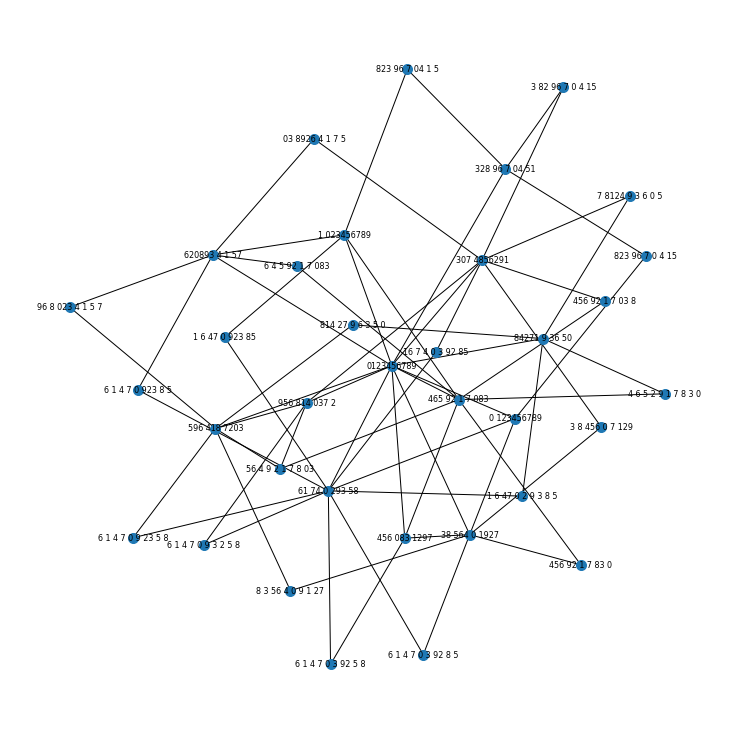

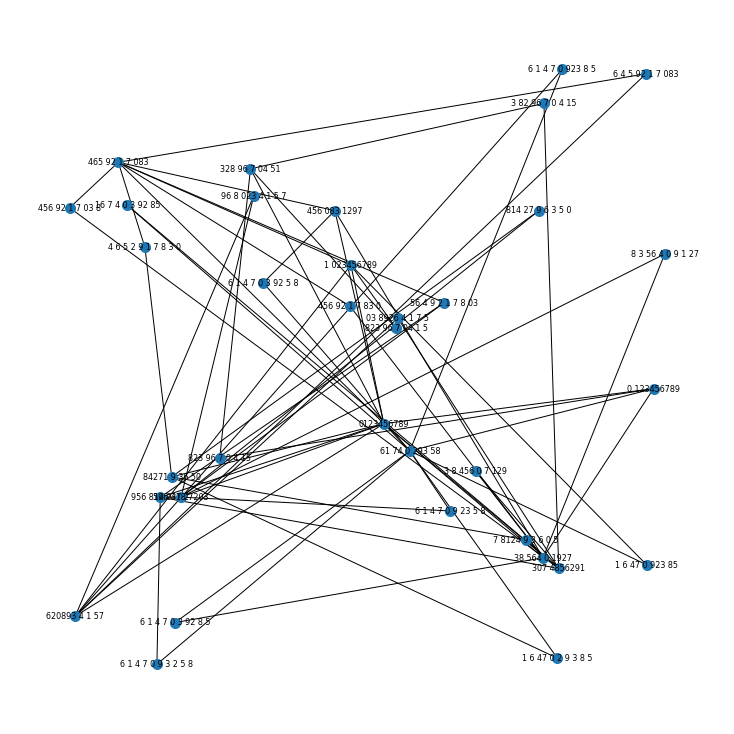

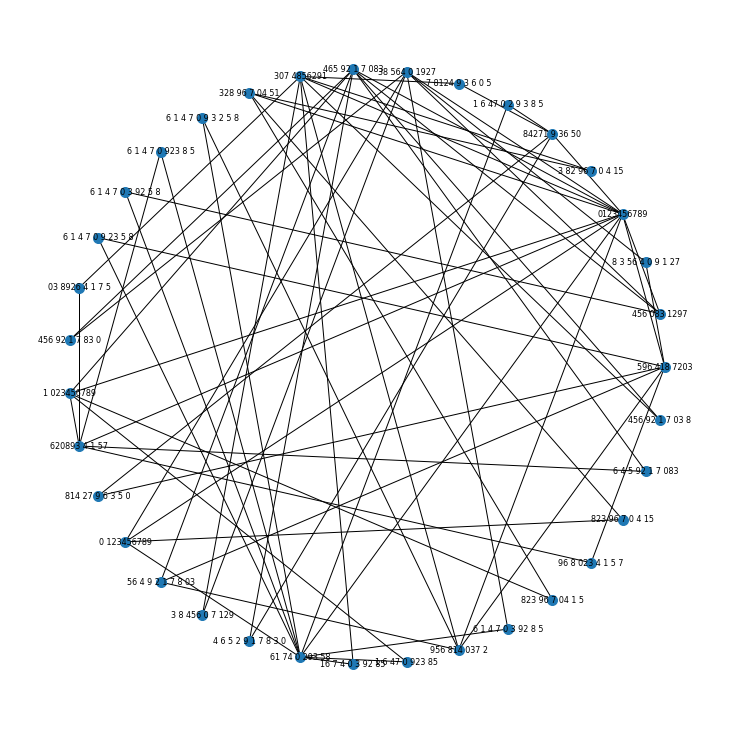

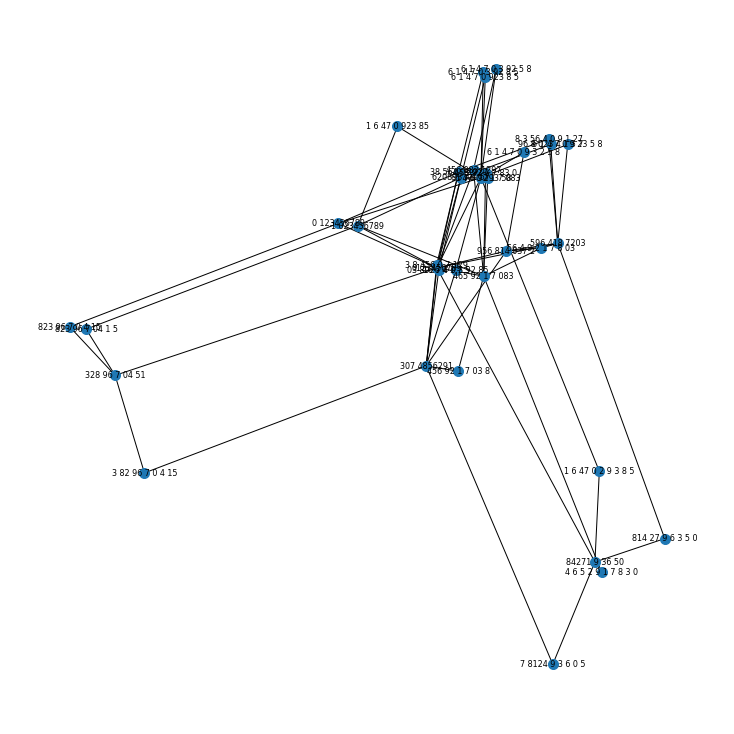

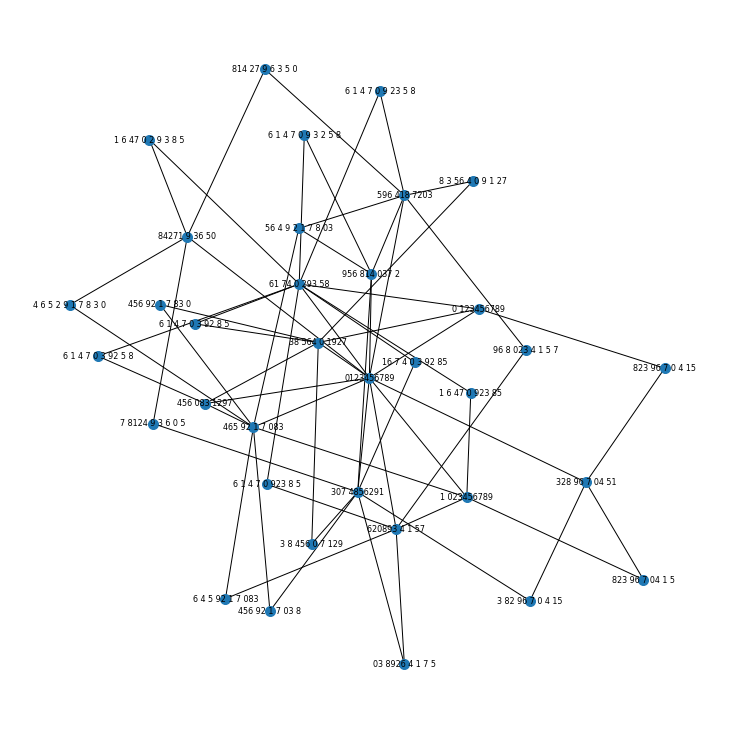

In [99]:
options = {
    # 'node_color': 'black',
    'node_size': 100,
    'font_size': 8
}
fig = plt.figure(1, figsize=(10, 10))
nx.draw(H, with_labels=True, font_weight='normal', **options)
plt.show()
fig = plt.figure(1, figsize=(10, 10))
nx.draw_random(H, with_labels=True, font_weight='normal', **options)
plt.show()
fig = plt.figure(1, figsize=(10, 10))
nx.draw_circular(H, with_labels=True, font_weight='normal', **options)
plt.show()
fig = plt.figure(1, figsize=(10, 10))
nx.draw_spectral(H, with_labels=True, font_weight='normal', **options)
plt.show()
fig = plt.figure(1, figsize=(10, 10))
nx.draw_spring(H, with_labels=True, font_weight='normal', **options)
plt.show()

In [110]:
# Graph = nx.Graph()
# for partns in poset.size2partns.values():
#   Graph.add_nodes_from(partns)
# Graph.add_nodes_from(poset.partns)

# for partns in poset.size2partns.values():
#   for partn in partns:
#     for child in poset.part2descendents[partn]:
#       Graph.add_edge(partn, child)
#     for parent in poset.part2ancestors[partn]:
#       Graph.add_edge(parent, partn)
#     for child in poset.part2children[partn]:
#       Graph.add_edge(partn, child)
#     for parent in poset.part2parents[partn]:
#       Graph.add_edge(parent, partn)
      

# def mapper(partn):
#   return ' '.join(''.join(map(str, subspace.indices.tolist())) for subspace in partn.subspaces)

# H = nx.relabel_nodes(Graph, mapper)
# options = {
#     # 'node_color': 'black',
#     'node_size': 100,
#     'font_size': 8
# }
# fig = plt.figure(1, figsize=(10, 10))
# nx.draw(H, with_labels=True, font_weight='normal', **options)
# plt.show()
for i in poset.size2partns[1]:
  print(i.__hash__())

981049745503395499
4336098672432642599
-5034296714931028633
-1612478730846227853
-8948672368601703211
2158655818771928987
-6352935641332444038
6492610206129634995
2390803154967226502
2133682973520889270
-3060772790864915596
1832288538759098813
-135055855598619716
4287358941193467659
7930158053472123829
-6481147992764203710
-1002711822045964733
2151761109323809076
573162408023619528
-2573953036790852946
2600738407983584277


In [ ]:
"""
THIS IS MORE A TESTING RELATED CODE
TO CHECK IF THINGS ARE IN GOOD CONDITION, SO I WILL PUT MOST OF COMMENTED CODE WHICH CAN BE USED FOR SMALL UNIT TESTING
"""

# CHECK HOW OUR RANDOM PARTITION LOOKS LIKE
# p1 = random_partitions[0]
# p2 = random_partitions[1]
# for idx, i in enumerate(random_partitions):
#   for j in random_partitions[idx:]:
#     k = i.is_coarser(j)
#     if k != 0:
#       i.print_basis_idx()
#       j.print_basis_idx()
#       print(k, sep='  =>   ')


# TO TEST THE IS_COARSER
# subspaces_2 = [
#   Subspace([np.ones(10)], [0]),
#   Subspace([np.ones(10), np.ones(10)], [1,2]),
#   Subspace([np.ones(10), np.ones(10)], [3,4]),
#   Subspace([np.ones(10), np.ones(10)], [5,6]),
#   Subspace([np.ones(10), np.ones(10)], [7,8]),
#   Subspace([np.ones(10), np.ones(10)], [9]),
# ]
# subspaces_1 = [
#   Subspace([np.ones(10)], [0,1,2,3,4,5,6]),
#   Subspace([np.ones(10)], [7,8, 9]),
# ]
# p1 = SubspacePartition(subspaces_2)
# p2 = SubspacePartition(subspaces_1)
# p1.print_basis_idx()
# p2.print_basis_idx()
# print(p1.is_coarser(p2))


# CHECK JOIN AND MEET
# random_partitions[0].print_basis_idx(), random_partitions[1].print_basis_idx()
# p = SubspacePartition.join(random_partitions[0], random_partitions[1], random_basis)
# p.print_basis_idx()
# p.print_partition()